# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Speech Recognition

## Notebook 3: Project Instructions

## Yuri Balasanov, Alexander Doynikov, Alex Petukhov &copy; iLykei 2018

##### Main texts: 

##### Artificial Intelligence with Python. A Comprehensive Guide to Building Intelligent Apps for Python Beginners and Developers, Prateek Joshi, &copy; Packt Publishing  2017

##### [A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition, Lawrence R. Rabiner, Proceedings of the IEEE, Vol. 77, No. 2, Feb. 1989](https://ieeexplore.ieee.org/document/18626/)

##### [Documentation for **pydub**](https://github.com/jiaaro/pydub/blob/master/API.markdown)

This notebook contains instructions for the project. 

# Collecting data for training sample

To train an Automatic Speech Recognizer (ASR) collect recordings of waveforms of numerals from as many people as possible. Organize the records to use them for training models.


## Recording

Use any software that can create recordings in the form of uncompressed raw .WAV files with 1 channel, sampling rate 8,000 Hz (8 kHz), 16 bit sample size (precision) and 16-bit signed integer PCM (Pulse-Code Modulation) data encoding.

A popular command line utility that can do it is Sox  - Sound  eXchange - available [here](http://sox.sourceforge.net/).

To make a recording of the required quality wit SOX follow the steps:
- Download and install `sox`
- Connect microphone or use the built in one and check that it is functioning properly
- Start recording by executing command: `rec -c 1 -r 8k filename.wav`. <br>
Here `-c 1` means recording mono (1 channel); `-r 8k` means recording with sampling rate of 8 kHz
- Stop recording by executing `Ctrl+C`. Check the file parameters: `soxi filename.wav`. Parameter `bit-rate` in the output is a measure of the amount of storage occupied by an encoded audio signal over a unit of time
- Play the file using any media player

If any other recording software used it is recommended to make .WAV files with the same characteristics and without any metadata.

It is recommended to make several recordings with each speaker. Each recording contains spoken numbers from "zero" to "nine" with clear pauses of at least about 1 sec between them. 

## Splitting

Collected records should have one or several .WAV files from each speaker with utterances of numerals from "zero" to "nine" separated by silent segments of about 1 second long.

Before training models split each record and store utterances in separate .WAV files. 

A commonly used python package for splitting by silence is `pydub`. <br>
Install it by either `conda install -c auto pydub` or `pip install pydub`.

In [1]:
from pydub import AudioSegment as asg
from pydub.silence import split_on_silence
from pydub.playback import play

Select one file from each of the fruit names folders and combine utterances in one segment to learn how to split utterances by silence.

In [2]:
fruit_paths = ['./data/apple/apple01.wav',
               './data/banana/banana01.wav',
               './data/kiwi/kiwi01.wav',
               './data/lime/lime01.wav',
               './data/orange/orange01.wav',
               './data/peach/peach01.wav',
               './data/pineapple/pineapple01.wav']
fruit_sequence = asg.silent()
for f_path in fruit_paths:
    fruit_sequence = fruit_sequence + asg.from_file(f_path) + asg.silent()

play(fruit_sequence)

Save the file with fruit names.

In [3]:
fruit_sequence.export('fruit_seq.wav',format="wav")

<_io.BufferedRandom name='fruit_seq.wav'>

Check parameters of the saved file by running `soxi fruit_seq.wav`. <br>
The sample frequency may need to be transformed back to 8 kHz:

In [4]:
fruit_sequence = fruit_sequence.set_frame_rate(8000)
fruit_sequence.export('fruit_seq.wav',format="wav")

<_io.BufferedRandom name='fruit_seq.wav'>

Read the file and split it into separate utterances by silence. <br>
First, select parameters for splitting, for example, as:
- Minimum length of silence to split as 200 ms
- Threshold for definition of silence in dB relative to full scale (dBFS) as default value of (-16).

Run function `split_on_silence()`

In [5]:
all_utterances = asg.from_file('fruit_seq.wav')

silence_len = 200 # (in ms) minimum length of a silence to be used for a split
thresh = -50 # (in dBFS) anything quieter than this will be considered silence. default=-16

separate_utterances = split_on_silence(all_utterances,
                                       min_silence_len=silence_len, 
                                       silence_thresh=thresh 
                                       )

print(len(separate_utterances))

7


Note that there was no split: level of threshold for silence is too high to detect any silence segments. <br>
Change the threshold to -20. There is only 2 segments after split. <br>
Change the threshold to -30. Now there are 7 segments. Play them all and check how well the utterances are separated.

In [6]:
play(separate_utterances[3])

Some of the words appear truncated. <br>
Finally, with threshold equal to -50 all words can be heard.

This example shows how important and challenging is the problem of splitting speech into single word segments.

Select appropriate parameters for splitting or improve the splitting method by first analyzing characteristics of noise and then running `split_on_silence()`.

Collect all utterances of the same numeral in one folder. This is the training sample.

## Augmenting data

Like for other applications, data augmentation is an important method allowing better training of automatic speech recognition models.

This sections contains some code from [this post](https://www.kaggle.com/CVxTz/audio-data-augmentation) with significant modifications. The post describes some useful approaches to speech data augmentation: adding noise, stretching and rolling, shifting the pitch.

In [7]:
import numpy as np
import random
import scipy.io.wavfile as wavfile
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa

%matplotlib inline

In [8]:
def plot_waveform(signal,sampling_freq):
    time_axis=1000*np.arange(0,len(signal),1)/float(sampling_freq)
    plt.plot(time_axis,signal,color='black')
    plt.xlabel('Time (milliseconds)')
    plt.ylabel('Amplitude')
    plt.title('Waveform of Utterance')
    plt.show()

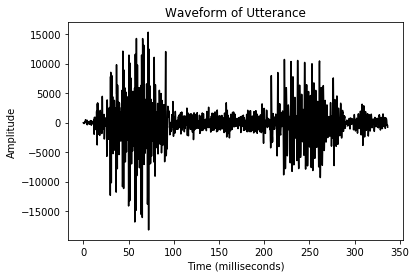

In [9]:
sampling_freq, signal = wavfile.read('./data/apple/apple01.wav')
plot_waveform(signal,sampling_freq)

### Adding white noise

Add random white noise to the utterance.

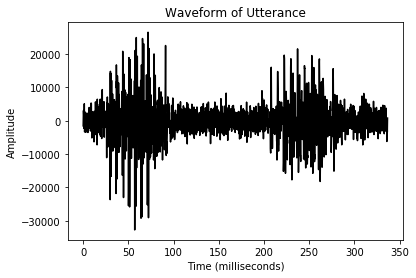

In [10]:
wn = np.random.randn(len(signal)) # generate white noise
signal_wn = signal + 1000*wn # add white noise to signal

# Scale it to 16-bit integer values
scaling_factor = np.power(2, 15) - 1
signal_wn_normalized = signal_wn / np.max(np.abs(signal_wn))
signal_wn_scaled = np.int16(signal_wn_normalized * scaling_factor)

plot_waveform(signal_wn_scaled,sampling_freq)

Write modified signal to a new file.

In [11]:
wavfile.write('apple_noise.wav', sampling_freq, signal_wn_scaled)

Read the file and play it.

In [12]:
play(asg.from_file('apple_noise.wav'))

### Shifting the sound

Shifting is equivalent to rolling the time series of signal by a specified shift. As the signal shifts forward the last values become first.

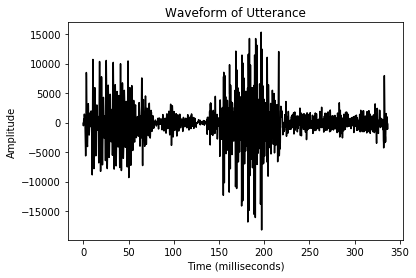

In [13]:
signal_roll = np.roll(signal, shift=1000)
plot_waveform(signal_roll,sampling_freq)

In [14]:
wavfile.write('apple_roll.wav', sampling_freq, signal_roll)
play(asg.from_file('apple_roll.wav'))

### Stretching sound

Stretching sound means changing the length of the signal which typically leads to change in the frequency of the signal.

To stretch the signal use package `librosa`.

Create a function that stretches given signal by a certain rate.

In [15]:
def stretch(data, rate=1):
    data = data.astype(float) # time_stretch() accepts floating format
    data = librosa.effects.time_stretch(data, rate) # stretching

    # Scale it to 16-bit integer values
    scaling_factor = np.power(2, 15) - 1
    data_normalized = data / np.max(np.abs(data))
    data_scaled = np.int16(data_normalized * scaling_factor)

    return data_scaled

For comparison print duration and length of the original signal.

In [16]:
# Create sound in the format of pydub AudioSegment
sound_original = asg(data=signal,sample_width=2,frame_rate=sampling_freq,channels=1)
print('Original duration: ',sound_original.duration_seconds,', Length original: ',len(signal))
play(sound_original)

Original duration:  0.168375 , Length original:  2694


Now stretch the signal with coefficient 0.8.

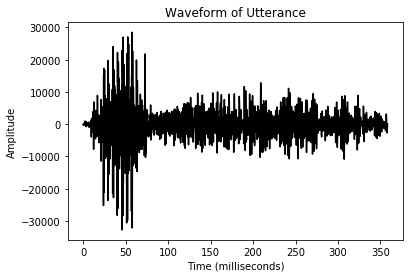

Stretch 80% duration:  0.1792 , Length stretch 80%:  3584


In [17]:
signal_stretch_80 =stretch(signal, 0.8)
plot_waveform(signal_stretch_80,int(sampling_freq/0.8)) # adjust sampling frequency accordingly
sound_stretch80 = asg(signal_stretch_80,sample_width=2,frame_rate=int(sampling_freq/0.8),channels=1)
print('Stretch 80% duration: ',sound_stretch80.duration_seconds,', Length stretch 80%: ',len(signal_stretch_80))
play(sound_stretch80)

Export the file to .WAV format.

In [18]:
sound_stretch80.export('apple_stretch80.wav',format='wav')

<_io.BufferedRandom name='apple_stretch80.wav'>

Check the saved file. Note that sample rate increased. Read the file and adjust the sampling rate back to 8 kHz.

In [19]:
sound = asg.from_wav('apple_stretch80.wav')
sound = sound.set_frame_rate(8000)
sound.export('apple_stretch80_adj.wav',format='wav')
play(sound)

Now stretch the signal with coefficient 1.2.

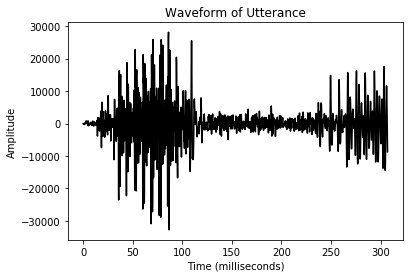

Stretch 120% duration:  0.15361536153615363 , Length stretch 120%:  2048


In [20]:
signal_stretch120 =stretch(signal, 1.2)
plot_waveform(signal_stretch120,int(sampling_freq/1.2))
sound_stretch120 = asg(signal_stretch120,sample_width=2,frame_rate=int(sampling_freq/1.2),channels=1)
print('Stretch 120% duration: ',sound_stretch120.duration_seconds,', Length stretch 120%: ',len(signal_stretch120))

Again, export the stretched sound to file, read it back and adjust the sampling frequency. 

In [21]:
sound_stretch120.export('apple_stretch120.wav',format='wav')
sound120 = asg.from_wav('apple_stretch120.wav')
sound120_adj = sound120.set_frame_rate(8000)
sound120_adj.export('apple_stretch120_adj.wav',format='wav')

<_io.BufferedRandom name='apple_stretch120_adj.wav'>

Check parameters of both adjusted files and play them to compare them with the original.

In [22]:
play(asg.from_wav('./data/apple/apple01.wav'))
play(asg.from_wav('apple_stretch120_adj.wav'))
play(asg.from_wav('apple_stretch80_adj.wav'))

# Training model

## Organizing data

Collect all original and augmented files together in subfolders corresponding to spoken numerals.

Now it is time to train a model for each subfolder.

## Selecting parameters, extracting features

Training a model for one numeral includes the following <a href="https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FSpeech%20Recognition%2FMScA32017_AMLAI_SpeechRecognition_1.ipynb" target="_blank">(see notebook 1)</a> :
- Deciding how many states and how many MFCC coefficients is necessary to train a model for a given numeral. Check AIC values for different combinations and select a reasonable one. It is possible that different words can be better detected by models with different combinations 
- For the selected combination extract MFCC features for each frame of each sample. The resulting feature matrix has number of rows equal to the total number of frames in all available samples of the word and number of columns equal to the selected number of cepstrum coefficients
- Train HMM with the selected number of states and observations equal to the features

Save (pickle) models for each word to a file.

# Automatic speech recogninition

## Test data

Received test data archive will contain a folder with multiple .WAV files. Each file is a telephone number: a spoken sequence of 10 numbers separated by short silence segments. Telephone numbers are recorded by different speakers. 

## Splitting phone numbers into separate numbers

Before scoring models for each numeral split telephone numbers into single spoken numerals. Use the algorithm  implemented for splitting training records in the section above. 

Store the test phone numbers in separate folders: returned solutions will need to be in the form of telephone numbers as well.

## Recognizing words by maximum likelihood

Loop through all test telephone numbers, for each telephone number loop through all numerals. 

For each spoken numeral: 
- Loop through the trained models
- For each model extract features for the numbers of HMM states and MFCC coefficients corresponding to that model
- Calculate log likelihood for each of the models and select model predicting the given numeral with highest log likelihood. Prediction by that model is the recognized word 


# Preparation of the results and submission

Collect all predicted numerals in telephone numbers combinations and upload them for grading.

## Instructions for submitting results

Recognized telephone numbers must be submitted as `.CSV` file containing 2 columns without any headers. The first column is the original file name (as it was downloaded) as ID, the second column is the recognized telephone number (without spacing). 

Submitted file should look something like this:

`1.wav, 2347789015` <br>  
`2.wav, 1078900356` <br> 
`3.wav, 9054403200` <br> 
`...`

## Calculation of score

Score for this project is calculated as **micro precision**:

Let $C_1,\ldots,C_k$ be $k$ classes for classification and let $$TP_i,FP_i,~i=1,\ldots,k,$$
be True Positive and False Positive rates for class $C_i$, correspondingly. Then micro precision is
$$Prec_{micro}=\frac{\sum_{i=1}^k TP_i}{\sum_{i=1}^k TP_i+\sum_{i=1}^k FP_i}.$$

# Test

In [23]:
from IPython.display import IFrame
def show(url,width=400,height=400):
    return IFrame(url, width, height)
show("https://shiny.ilykei.com/courses/AdvancedML/Speech_Recognition",
    width=500,height=300)